# Neural Network

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3 as sql
from util import *

def generate_sql_z_query(z_name: str, filters: dict):
	where_close = ""
	first_key = True
	for k, lf in filters.items():
		if first_key:
			first_key = False
		else:
			where_close += "AND "
		where_close += "("
		first = True
		for v in lf:
			if not first:
				where_close += " OR "
			else:
				first = False
			where_close += str(k)+"='"+str(v)+"'"
		where_close += ") "
	return "SELECT DISTINCT "+z_name+" FROM nn WHERE "+where_close

def generate_sql_xy_query(x_name: str, y_name: str, z_name: str, z_value, filters: dict, x_limit):
	where_close = z_name+" = '"+str(z_value)+"' "
	for k, lf in filters.items():
		where_close += "AND ("
		first = True
		for v in lf:
			if not first:
				where_close += " OR "
			else:
				first = False
			where_close += str(k)+"='"+str(v)+"'"
		where_close += ") "
	if x_limit > 0:
		where_close += "AND "+x_name+" < "+str(x_limit)+" "
	return ("SELECT "+x_name+","
			"min("+y_name+") as min,"
			"max("+y_name+") as max,"
			"median("+y_name+") as median,"
			"avg("+y_name+") as mean "
			"FROM nn "
			"WHERE "+where_close+""
			"GROUP BY "+x_name)

def consolidate_data_from_db(con, x_name: str, y_name: str, z_name: str, filters: dict, x_limit=-1):
	z_value_df = pd.read_sql_query(generate_sql_z_query(z_name, filters), con)
	cd = dict()
	for i in z_value_df.get(z_name):
		query = generate_sql_xy_query(x_name, y_name, z_name, i, filters, x_limit)
		print("Selecting data for", z_name, "=", i)
		#print(query)
		cd[i] = pd.read_sql_query(query, con)
	return cd

def generate_plot(con, x_arg_name, y_arg_name, z_arg_name, filters, save_to_file=True, x_limit=-1, x_name=None, y_name=None):
	if x_name is None:
		x_name = x_arg_name
	if y_name is None:
		y_name = y_arg_name
		
	cd = consolidate_data_from_db(con, x_arg_name, y_arg_name, z_arg_name, filters, x_limit)

	plt.figure()
	for a, d in cd.items():
		plt.plot(d.get(x_arg_name),d.get('median'), 
					label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
		plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
	if y_arg_name == "Error":
		plt.ylabel("Accuracy")
	elif y_arg_name == "Test_Error":
		plt.ylabel("Validation Accuracy")
	else:
		plt.ylabel(y_name.replace('_',' '))
	plt.xlabel(x_name.replace('_',' '))
	plt.legend()
	if save_to_file:
		problem_name = ""
		if "Problem" in filters.keys():
			for pb in filters["Problem"]:
				problem_name += str(pb) + "_"
		algo_name = "all_"
		if "Algorithm" in filters.keys():
			algo_name = '_'.join(map(str, filters["Algorithm"])) + '_'
		plt.savefig("../graphics/g_"+problem_name+algo_name+x_name+"_"+y_name+"_"+z_arg_name+".png")
	plt.show()

sns.set()
con = sql.connect("./problems.db")
# con.execute(('CREATE TABLE IF NOT EXISTS "nn" ('
# 	'"Algorithm" TEXT,'
# 	'"Layers" TEXT,'
# 	'"SA_initial_temperature" REAL,'
# 	'"SA_cooling_factor" REAL,'
# 	'"GA_population" REAL,'
# 	'"GA_mate_number" REAL,'
# 	'"GA_mutate_number" REAL,'
# 	'"Iteration" INTEGER,'
# 	'"Error" REAL,'
# 	'"Test_Error" REAL,'
# 	'"Time" REAL'
# ');'))
# con.execute('CREATE INDEX "ALGnn" on "nn" ("Algorithm");')
# con.execute('CREATE INDEX "LAYnn" on "nn" ("Layers");')
con.enable_load_extension(True)
con.load_extension("./extension-functions")
# df = pd.read_csv(
# 	"../stats/GenderTestErrors-RHC.csv",
# 	names=(
# 		"Algorithm", 
# 		"Layers", 
# 		"SA_initial_temperature",
# 		"SA_cooling_factor",
# 		"GA_population",
# 		"GA_mate_number",
# 		"GA_mutate_number",
# 		"Iteration",
# 		"Error",
# 		"Test_Error",
# 		"Time"
# 	)
# )
# df = pd.read_csv(
# 	"../stats/GenderTestErrors-SA.csv",
# 	names=(
# 		"Algorithm", 
# 		"Layers", 
# 		"SA_initial_temperature",
# 		"SA_cooling_factor",
# 		"GA_population",
# 		"GA_mate_number",
# 		"GA_mutate_number",
# 		"Iteration",
# 		"Error",
# 		"Test_Error",
# 		"Time"
# 	)
# )
df = pd.read_csv(
	"../stats/GenderTestErrors-GA.csv",
	names=(
		"Algorithm", 
		"Layers", 
		"SA_initial_temperature",
		"SA_cooling_factor",
		"GA_population",
		"GA_mate_number",
		"GA_mutate_number",
		"Iteration",
		"Error",
		"Test_Error",
		"Time"
	)
)
df.to_sql("nn", con, if_exists='append', index=False)

80000

In [47]:
print(pd.read_sql_query("SELECT Algorithm, max(Time)/10e9, max(Time/Iteration)/10e9, avg(Time/Iteration)/10e5 from nn GROUP BY Algorithm", con))

  Algorithm  max(Time)/10e9  max(Time/Iteration)/10e9  \
0        GA     1320.498726                  0.277016   
1       RHC      122.658278                  0.022020   
2        SA      147.525113                  0.037191   

   avg(Time/Iteration)/10e5  
0                499.811608  
1                 84.609309  
2                 82.421786  


Selecting data for Algorithm = RHC
Selecting data for Algorithm = SA


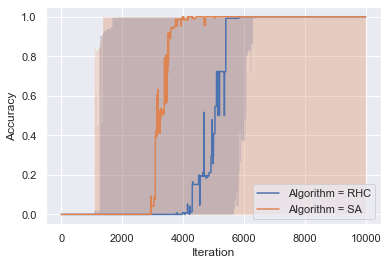

In [48]:
generate_plot(
	con=con,
	x_arg_name='Iteration',
	y_arg_name='Error',
	z_arg_name='Algorithm',
	filters={'Layers': [' 35', ' 15', ' 5', ' 30 10']},
	x_limit=100000
)

Selecting data for Algorithm = RHC
Selecting data for Algorithm = SA


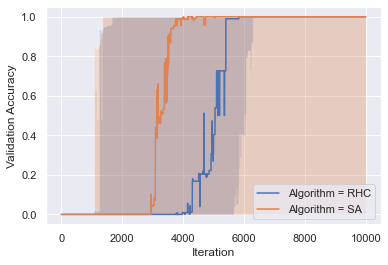

In [49]:
generate_plot(
	con=con,
	x_arg_name='Iteration',
	y_arg_name='Test_Error',
	z_arg_name='Algorithm',
	filters={'Layers': [' 35', ' 15', ' 5', ' 30 10']},
	x_limit=100000
)

## RHC

Selecting data for Layers =  5
Selecting data for Layers =  15
Selecting data for Layers =  35
Selecting data for Layers =  30 10


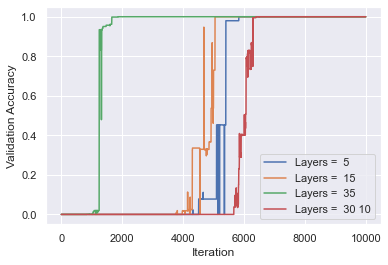

In [40]:
generate_plot(
	con=con,
	x_arg_name='Iteration',
	y_arg_name='Test_Error',
	z_arg_name='Layers',
	filters={'Algorithm': ['RHC']},
	x_limit=100000
)

## SA

Selecting data for Layers = 5
Selecting data for Layers = 15
Selecting data for Layers =  35
Selecting data for Layers =  30 10


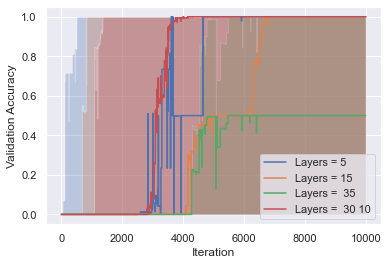

In [38]:
generate_plot(
	con=con,
	x_arg_name='Iteration',
	y_arg_name='Test_Error',
	z_arg_name='Layers',
	filters={'Algorithm': ['SA'], 'Layers': [' 35', '15', '5', ' 30 10']},
	x_limit=100000
)

Selecting data for SA_cooling_factor = 0.5
Selecting data for SA_cooling_factor = 0.6
Selecting data for SA_cooling_factor = 0.7
Selecting data for SA_cooling_factor = 0.7999999999999999
Selecting data for SA_cooling_factor = 0.8999999999999999
Selecting data for SA_cooling_factor = 1.0


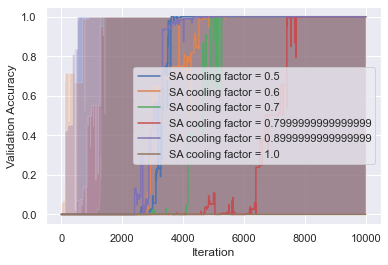

In [19]:
generate_plot(
	con=con,
	x_arg_name='Iteration',
	y_arg_name='Test_Error',
	z_arg_name='SA_cooling_factor',
	filters={'Algorithm': ['SA']},
	x_limit=100000
)

Selecting data for SA_initial_temperature = 50.0
Selecting data for SA_initial_temperature = 100.0
Selecting data for SA_initial_temperature = 150.0


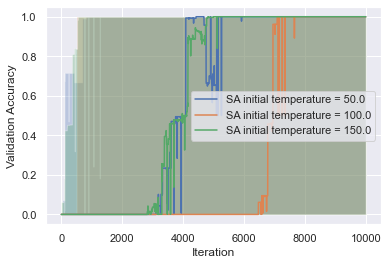

In [20]:
generate_plot(
	con=con,
	x_arg_name='Iteration',
	y_arg_name='Test_Error',
	z_arg_name='SA_initial_temperature',
	filters={'Algorithm': ['SA']},
	x_limit=100000
)

## GA

Selecting data for Layers = 5
Selecting data for Layers = 15


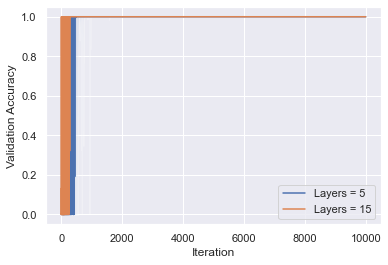

In [50]:
generate_plot(
	con=con,
	x_arg_name='Iteration',
	y_arg_name='Test_Error',
	z_arg_name='Layers',
	filters={'Algorithm': ['GA'], 'Layers': [' 35', '15', '5', ' 30 10']},
	x_limit=100000
)

Selecting data for GA_population = 350.0
Selecting data for GA_population = 650.0


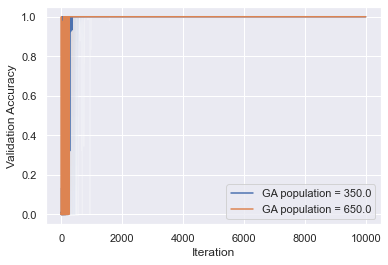

In [54]:
generate_plot(
	con=con,
	x_arg_name='Iteration',
	y_arg_name='Test_Error',
	z_arg_name='GA_population',
	filters={'Algorithm': ['GA']},
	x_limit=100000
)

Selecting data for GA_mate_number = 50.0
Selecting data for GA_mate_number = 300.0


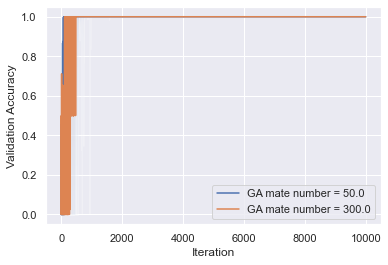

In [55]:
generate_plot(
	con=con,
	x_arg_name='Iteration',
	y_arg_name='Test_Error',
	z_arg_name='GA_mate_number',
	filters={'Algorithm': ['GA']},
	x_limit=100000
)

Selecting data for GA_mutate_number = 10.0


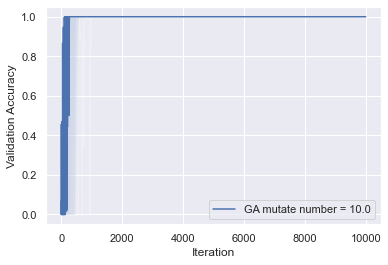

In [56]:
generate_plot(
	con=con,
	x_arg_name='Iteration',
	y_arg_name='Test_Error',
	z_arg_name='GA_mutate_number',
	filters={'Algorithm': ['GA']},
	x_limit=100000
)